## A map of Intracellular Electrophysiology Data on DANDI

I thought it would be a fun exercise to integrate all the open intracellular electrophysiology datasets from the [DANDI archive](https://dandiarchive.org/) into a single dataset, similar to projects in the transcriptomics world. See HYPOMAP: https://www.nature.com/articles/s42255-022-00657-y or MapMyCells: https://brain-map.org/bkp/analyze/mapmycells.

## Examining the data

Lets take a look at the overall embedding of the data. I opted to embed the data using UMAP, with the "cosine" metric

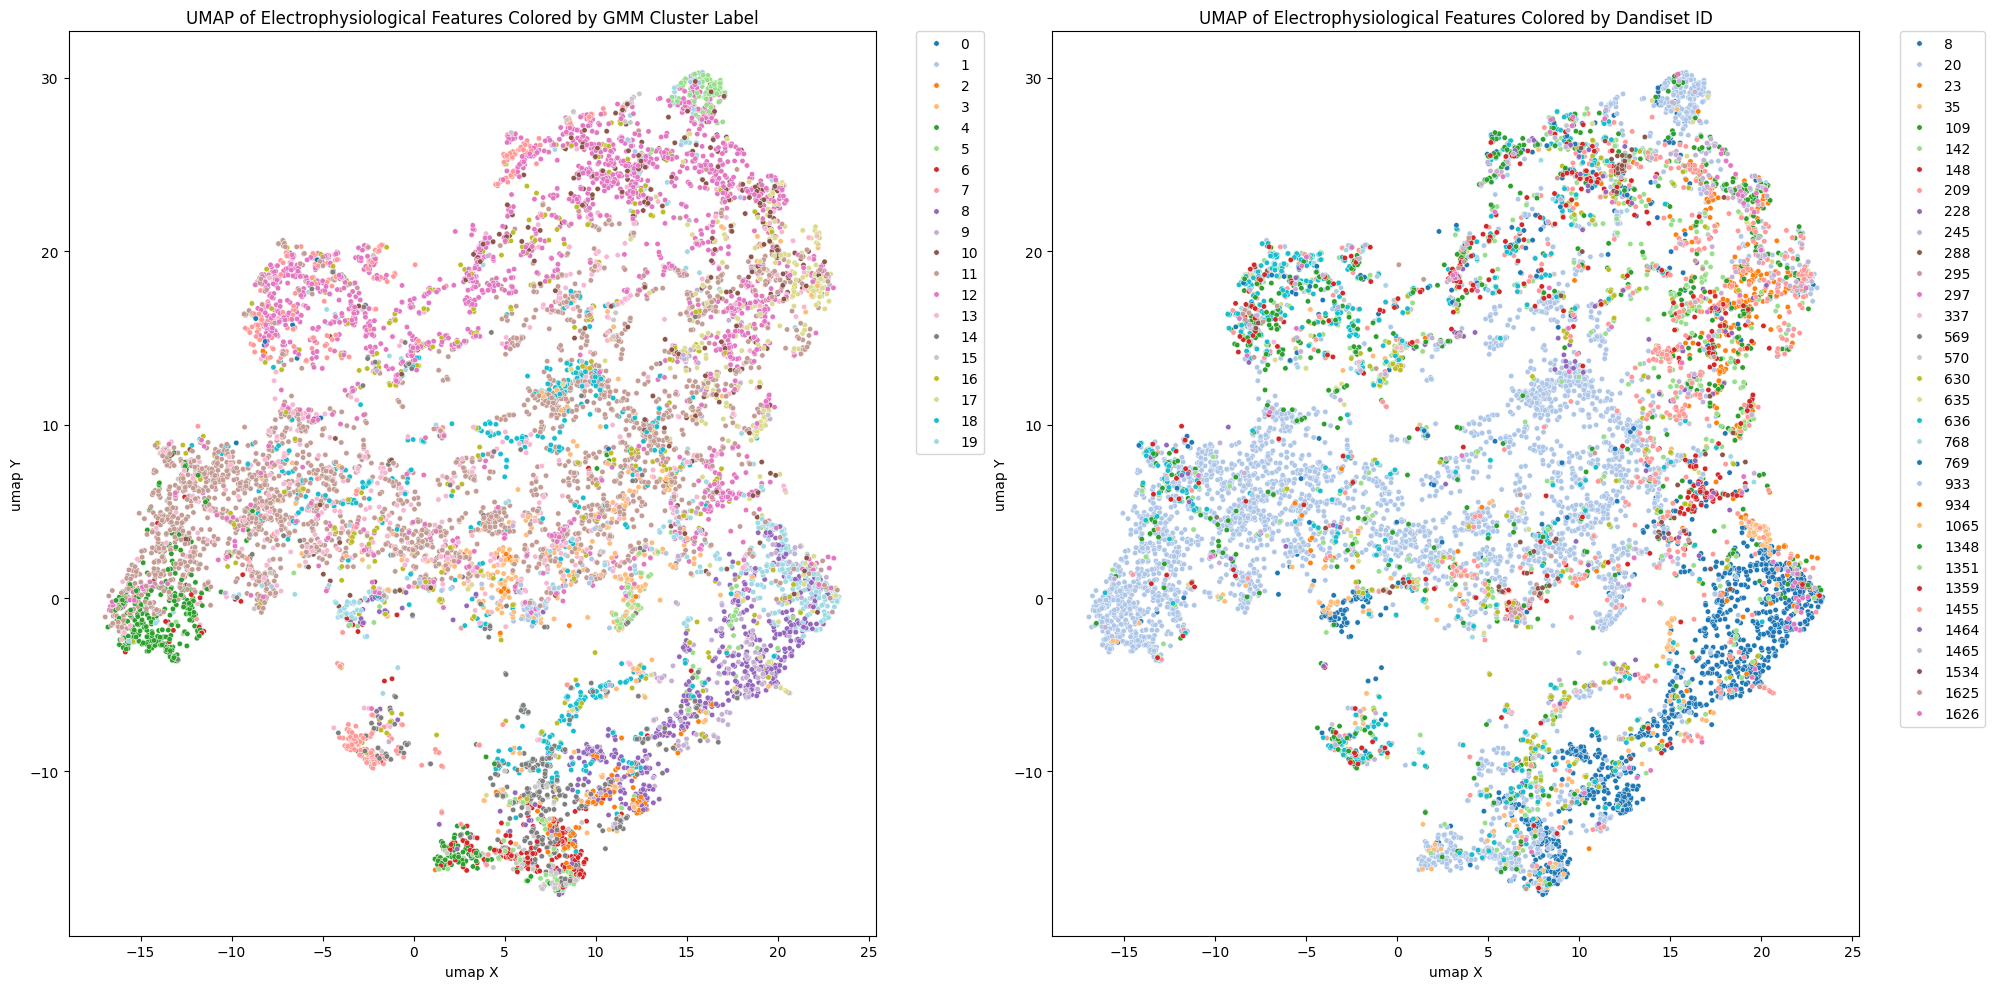

In [ ]:
#load the data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#compute the kNN of the features used for each cell
from sklearn.neighbors import NearestNeighbors
import os
from pyAPisolation.loadFile import loadNWB
from pyAPisolation.database.build_database import plot_data
from IPython.display import clear_output
data = pd.read_csv('all4.csv')
#plot a couple feature distributions
features_used = ['input_resistance', 'tau', 'v_baseline', 'sag_nearest_minus_100', 
       'ap_1_threshold_v_0_long_square', 'ap_1_peak_v_0_long_square',
       'ap_1_upstroke_0_long_square',
       'ap_1_width_0_long_square', 'ap_1_fast_trough_v_0_long_square',
       'ap_mean_threshold_v_0_long_square', 'ap_mean_peak_v_0_long_square',
       'ap_mean_upstroke_0_long_square',
       'ap_mean_width_0_long_square', 'ap_mean_fast_trough_v_0_long_square',
       'avg_rate_0_long_square', 'latency_0_long_square',]
selected_features = ['input_resistance', 'tau',  'ap_1_width_0_long_square', 'sag_nearest_minus_100']

#display the umap plot
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(data=data, x='umap X', y='umap Y', hue='GMM cluster label', palette='tab20', s=15, ax=ax[0])
ax[0].set_title('UMAP of Electrophysiological Features Colored by GMM Cluster Label')
#move the legend outside the plot
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
sns.scatterplot(data=data, x='umap X', y='umap Y', hue='dandiset_id', palette='tab20', s=15, ax=ax[1])
ax[1].set_title('UMAP of Electrophysiological Features Colored by Dandiset ID')
#move the legend outside the plot
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()


As a sanity check, we can look at how features map over a UMAP. Notably, there is a lot of controversy about [interpreting feature distributions on UMAPs](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1011288). However, we are just using it as a general sanity check to ensure the UMAP is embedding logically and not exploiting any bias in the data.

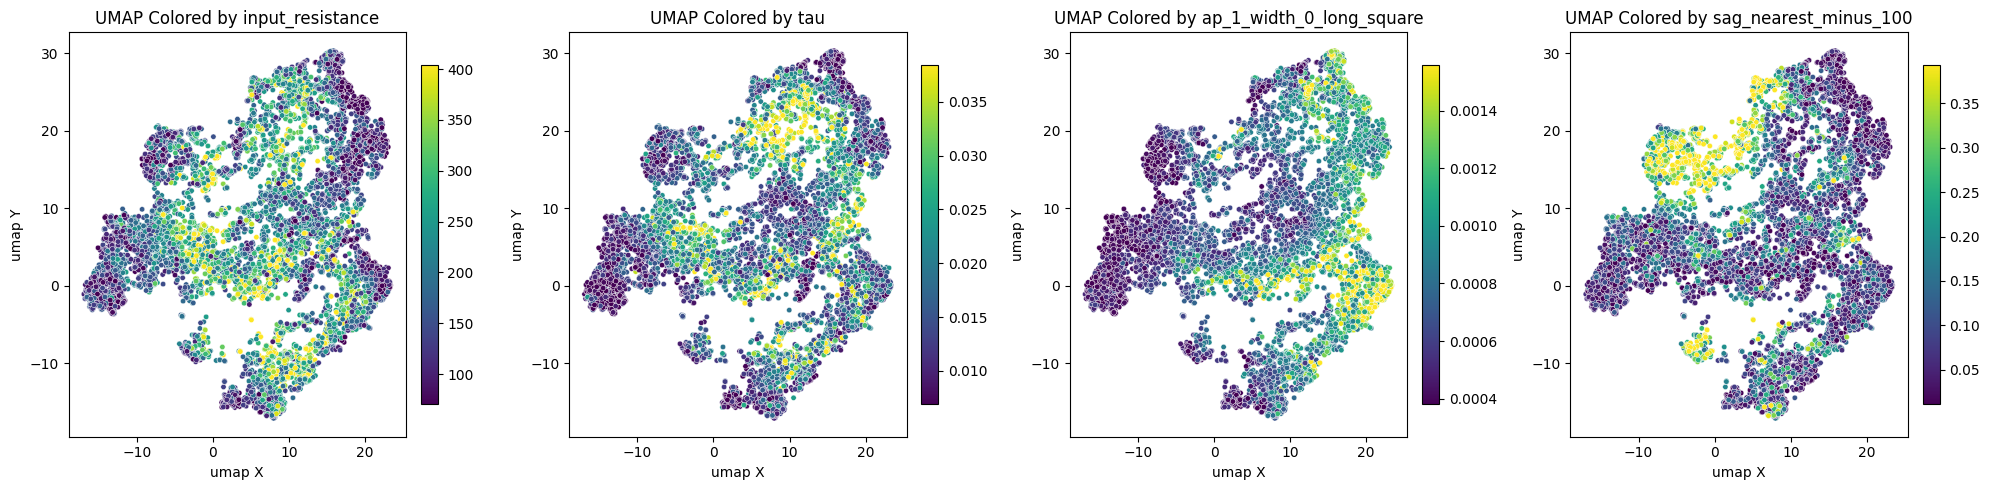

In [66]:
#run a grid of plots of feature distributions on the UMAP
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, feature in enumerate(selected_features):
    row = 1
    col = i % 4
    #ensure to use viridis palette for continuous features
    #clip the feature to the 5th and 95th percentile for better visualization
    clipped_feature = data[feature].clip(lower=data[feature].quantile(0.05), upper=data[feature].quantile(0.95))
    sns.scatterplot(data=data, x='umap X', y='umap Y', hue=clipped_feature, palette='viridis', s=15, ax=axes[col])
    axes[col].set_title(f'UMAP Colored by {feature}')
    #remove the legend for clarity
    axes[col].legend_.remove()
    #add a colorbar
    norm = plt.Normalize(vmin=clipped_feature.min(), vmax=clipped_feature.max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=axes[col], orientation='vertical', fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
    

Here, we can see the UMAP is clustering feature values together in a somewhat coherent manner. Promisingly (to me) is the mapping -x to +x mapping of action potential width, a common feature for very rudimentary electrophysiological cell typing in the cortical regions (https://www.nature.com/articles/s41593-019-0417-0). 

From here, we can also look at cells' K-NN neighbours in the dataset, a sanity checks to see if the cells match qualitatively across datasets. We would expect cells with similar electrophysiology phenotypes to group together


In [67]:

features_data = data[features_used].values
nbrs = NearestNeighbors(n_neighbors=15, algorithm='auto').fit(features_data)
distances, indices = nbrs.kneighbors(features_data)

#get some random cells to visualize
np.random.seed(40)
random_cells = np.random.choice(data.index, size=5, replace=False)

#load the file, point towards your dandi cache
folder = f"/media/smestern/Expansion/dandi/"

#get the nearest neighbor that does not belong to the same dandiset
cells_out = {}
for cell in random_cells:
    cell_dandiset = data.loc[cell, 'dandiset_id']
    neighbor_found = False
    neighbors = []
    neighbor_idx_count = 0
    for neighbor_idx in indices[cell][1:]:  # skip the first one as it is the cell itself
        neighbor_dandiset = data.loc[neighbor_idx, 'dandiset_id']
        if neighbor_dandiset != cell_dandiset:
            neighbor_found = True
            
            neighbour_path = data.loc[neighbor_idx, 'specimen_id']
            neighbor_region = data.loc[neighbor_idx, 'brain_region']
            neighbor_species = data.loc[neighbor_idx, 'species']
            neighbour_cell = plot_data(0, [os.path.join(folder, neighbour_path)], overwrite=True, save=False, stim_override='')
            if 'sweep_ys' not in neighbour_cell:
                continue  # skip if data could not be loaded properly
            n_cell = {'dandi_id': neighbor_dandiset, 'specimen_id': data.loc[cell, 'specimen_id'], 'sweep_ys': neighbour_cell['sweep_ys'], 'brain_region': neighbor_region, 'species': neighbor_species}
            neighbors.append(n_cell)
            neighbor_idx_count += 1
            clear_output()
            if neighbor_idx_count>=3:
                break
    if not neighbor_found:
        continue  # skip if no suitable neighbor found

    cell_path = data.loc[cell, 'specimen_id']
    cell_region = data.loc[cell, 'brain_region']
    cell_species = data.loc[cell, 'species']
    
    primairy_cell = plot_data(0, [os.path.join(folder, cell_path)], overwrite=True, save=False, stim_override='')
    print(f"Cell {cell} from Dandiset {cell_dandiset}:")
    neighbour_cell = plot_data(0, [os.path.join(folder, neighbour_path)], overwrite=True, save=False, stim_override='')
    print(f"Nearest Neighbor {neighbor_idx} from Dandiset {neighbor_dandiset}:")
    cells_out[cell] = {'cell_y': primairy_cell['sweep_ys'], 'neighbors': neighbors, 'dandi_id': cell_dandiset, 'specimen_id': cell_path,  'brain_region': cell_region, 'species': cell_species}
    plt.close('all')
    clear_output()
clear_output()

/tmp/ipykernel_1156517/2578950910.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


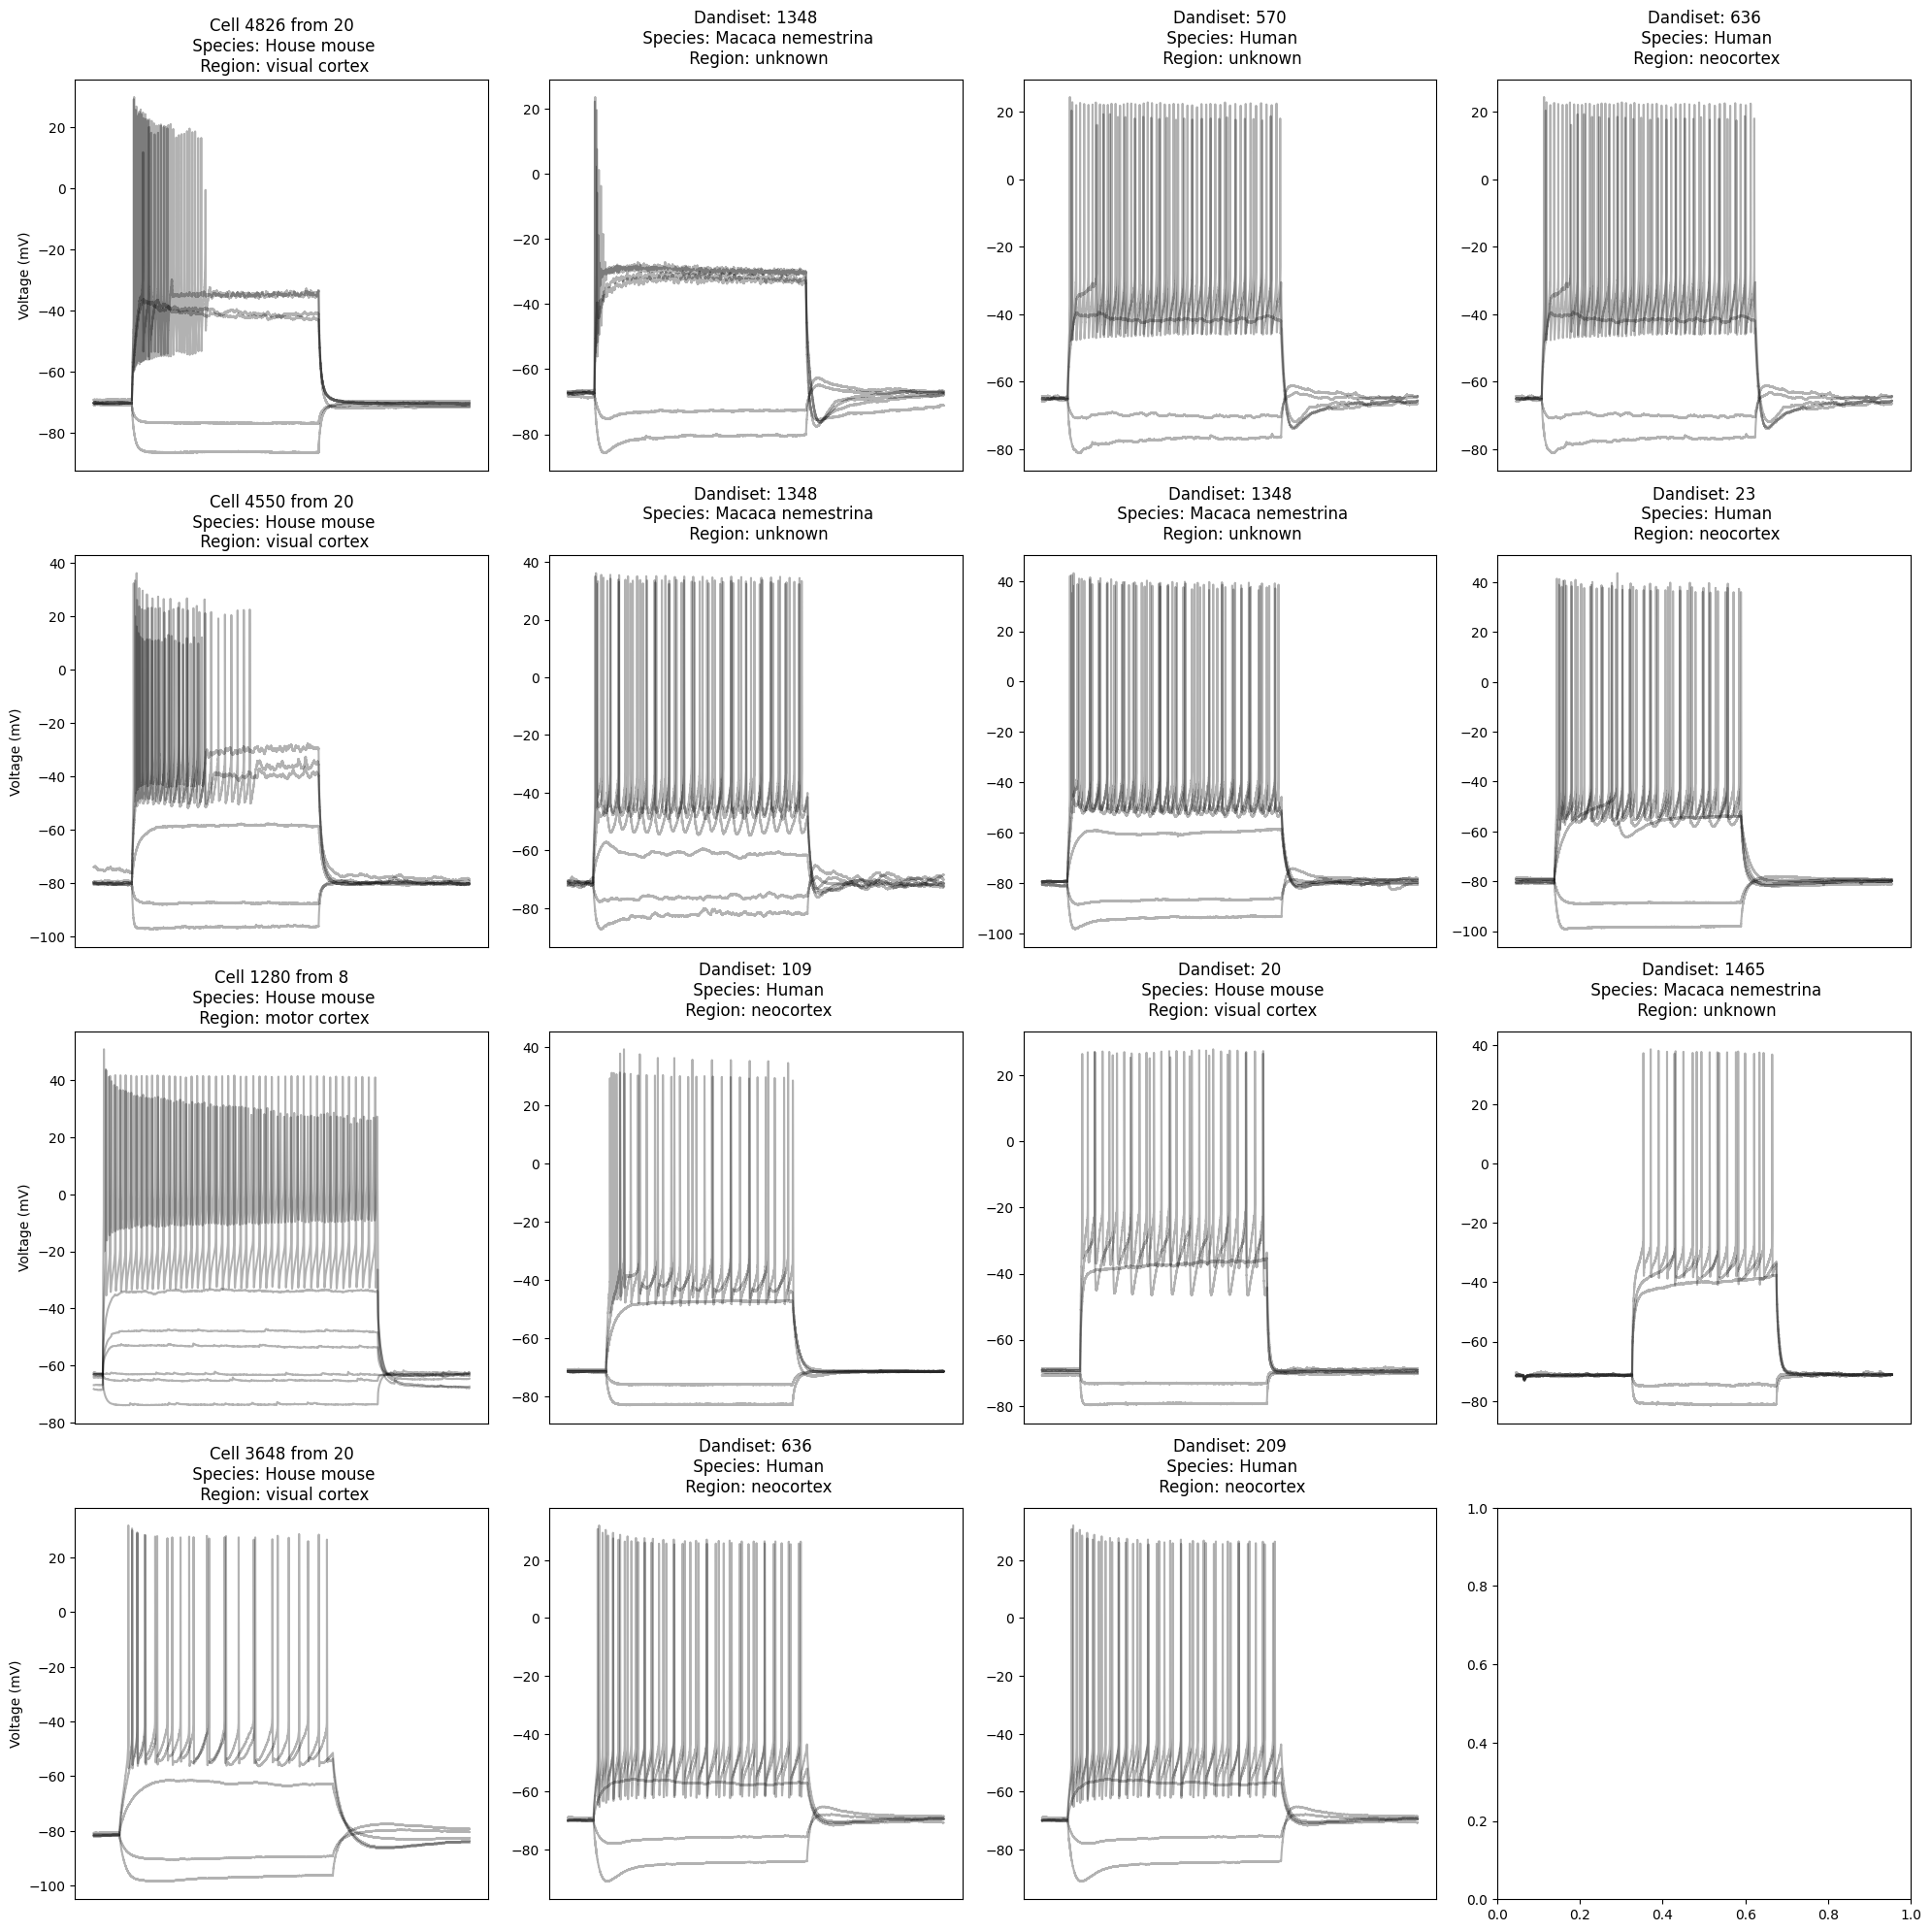

In [68]:
fig, ax = plt.subplots(len(cells_out), 4, figsize=(20,20))
i = 0

for cell_id, traces in cells_out.items():
    for sweep_y in traces['cell_y']:
        ax[i, 0].plot(sweep_y, color='k', alpha=0.3)
    for j, minor_cell in enumerate(traces['neighbors']):
        for sweep_y in minor_cell['sweep_ys']:
            ax[i, j+1].plot(sweep_y, color='k', alpha=0.3)
        ax[i, j+1].set_title(f'Dandiset: {minor_cell["dandi_id"]}\n Species: {minor_cell["species"]}\n Region: {minor_cell["brain_region"]}', y=1.02)
        #delete x and y ticks for clarity
        ax[i, j+1].set_xticks([])
    ax[i, 0].set_title(f'Cell {cell_id} from {traces["dandi_id"]}\n Species: {traces["species"]}\n Region: {traces["brain_region"]}')
    ax[i, 0].set_ylabel('Voltage (mV)')
    ax[i, 0].set_xticks([])
    i += 1
plt.tight_layout()
fig.show()


The results are interesting. Qualitatively, cells with similar ephys fingerprints do seem to be neighbours (regardless of species). 
For example: Cell 1280 (row 4) and its neighbours show an irregular bursting (or stuttering) phenotype: https://pmc.ncbi.nlm.nih.gov/articles/PMC1941757/.

# Interesting landmarks

## The Fast Spikers and Broad Spikers:

As noted above, spike width is a common metric for rapid, rough cell typing of cortical neurons (particularly in the extracellular electrophysiology world). The fast spikers are generally thought to be putative inhibitory neurons (likely Pv cells), whereas the broad spikers are thought to be putative excitatory pyramidal neurons. We now know that this distinction is not as clear-cut, as not all inhibitory neurons show "fast spikes" (see [Gouwens et al. 2019](https://www.nature.com/articles/s41593-019-0417-0)), and non-cortical regions do not have such clear cell-types (save for maybe the hippocampus). Regardless, as a first pass, looking at the distinction between the narrow and broad spikers seems like a good idea. The UMAP shows a pretty clear separation of spike width along the x-axis

/tmp/ipykernel_1156517/1577241347.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


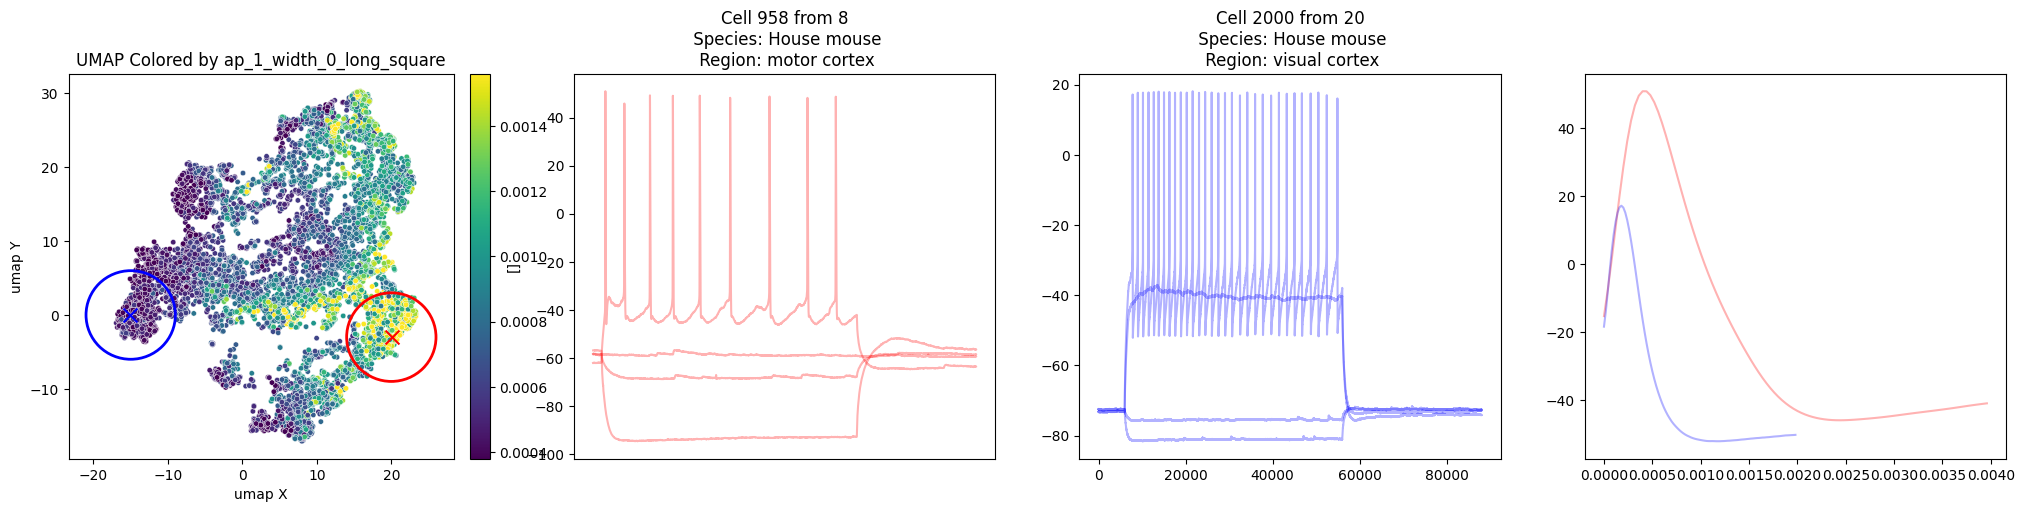

In [69]:
fig, ax = plt.subplots(1, 4, figsize=(25,5))
feature = "ap_1_width_0_long_square"
clipped_feature = data[feature].clip(lower=data[feature].quantile(0.05), upper=data[feature].quantile(0.95))
sns.scatterplot(data=data, x='umap X', y='umap Y', hue=clipped_feature, palette='viridis', s=15, ax=ax[0])
ax[0].set_title(f'UMAP Colored by {feature}')
#remove the legend for clarity
ax[0].legend_.remove()
#add a colorbar
norm = plt.Normalize(vmin=clipped_feature.min(), vmax=clipped_feature.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax[0], orientation='vertical', fraction=0.046, pad=0.04)
#draw circles around the sag sections
circle1 = plt.Circle((20, -3), 6, color='red', fill=False, linewidth=2)
ax[0].add_patch(circle1)
cirle2 = plt.Circle((-15, 0), 6, color='blue', fill=False, linewidth=2)
ax[0].add_patch(cirle2)
#pick out 2 cells closest to the center of the circles
center1 = np.array([20, -3])
center2 = np.array([-15, 0])
umap_coords = data[['umap X', 'umap Y']].values
distances1 = np.linalg.norm(umap_coords - center1, axis=1)
closest_cell1 = np.argmin(distances1)
distances2 = np.linalg.norm(umap_coords - center2, axis=1)
closest_cell2 = np.argmin(distances2)
print(f"Closest cell to circle 1: {closest_cell1}, width value: {data.loc[closest_cell1, feature]}")
print(f"Closest cell to circle 2: {closest_cell2}, width value: {data.loc[closest_cell2, feature]}")
#put 'x' markers on the closest cells
ax[0].scatter(data.loc[closest_cell1, 'umap X'], data.loc[closest_cell1, 'umap Y'], color='red', s=100, marker='x')
ax[0].scatter(data.loc[closest_cell2, 'umap X'], data.loc[closest_cell2, 'umap Y'], color='blue', s=100, marker='x')


for i, cell_in in enumerate([closest_cell1, closest_cell2]):
    cell_path = data.loc[cell_in, 'specimen_id']
    cell_region = data.loc[cell_in, 'brain_region']
    cell_species = data.loc[cell_in, 'species']
    primairy_cell = plot_data(0, [os.path.join(folder, cell_path)], overwrite=True, save=False, stim_override='')
    for sweep_x, sweep_y in zip(primairy_cell['sweep_xs'], primairy_cell['sweep_ys']):
        ax[i+1].plot(sweep_y, color='r' if i==0 else 'b', alpha=0.3, )
        if np.any(sweep_y>-20):
            idx_thres = np.where(sweep_y>-20)[0][0]
            ax[-1].plot(sweep_x[idx_thres:idx_thres+100] - sweep_x[idx_thres], sweep_y[idx_thres:idx_thres+100], color='r' if i==0 else 'b', alpha=0.3, )
            break
    ax[i+1].set_title(f'Cell {cell_in} from {data.loc[cell_in, "dandiset_id"]}\n Species: {cell_species}\n Region: {cell_region}')
    plt.close(primairy_cell['fig_trace']); plt.close(primairy_cell['fi_fig'])
ax[1].set_ylabel([])
ax[1].set_xticks([])


clear_output()
fig.show()



The rightmost plot shows the first action potential from each cell. Here, you can see a pretty clear distinction between the fast spiker (cell 296) and the broad spiker (cell 1315). With 296 showing almost double the width. The caveat is that these cells are from disparate dandisets. Cell 296 is from dandiset 000020 (https://dandiarchive.org/dandiset/000020), whereas cell 1315 comes from 000008 (https://dandiarchive.org/dandiset/000008?search=000008&pos=1). These dandisets differ not only in their region (V1 vs motor), but also in their recording temperature (000020 at physiological, 000008 at room temp). Recording temp can have a large effect on [ion channel kinetics](https://link.springer.com/article/10.1007/BF00584655) and therefore action potential width.

## The sag islands:

There are two distinct islands in the UMAP embedding with a large measured "Sag". Sag in this case refers to the deflection present in the voltage when a cell is stimulated with a hyperpolarizing pulse. 

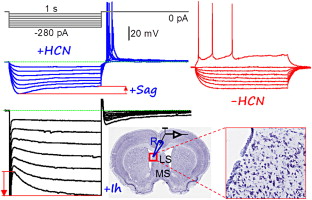

Image: A example of an HCN driven 'sag' from: https://doi.org/10.1016/j.neuropharm.2014.02.012


You may see a cell with sag described as having a h-current (or Ih), and this h-current is [thought to be driven by HCN channels](https://www.cell.com/neuron/fulltext/S0896-6273(18)30900-0). H-current bestows a number of different computation properites on neurons and expression differs across species and age (check out: [here](https://www.cell.com/neuron/fulltext/S0896-6273(18)30900-0), [or here](https://academic.oup.com/cercor/article/31/2/845/5927870?login=true)). Here sag is expressed as a ratio between steady state and absolutle deflection, you may see papers report absoulte or relative deflection in mV instead.

Closest cell to circle 1: 9616, sag value: 0.585063636302948
Closest cell to circle 2: 9582, sag value: 0.7321736812591553


/tmp/ipykernel_1156517/1549157567.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


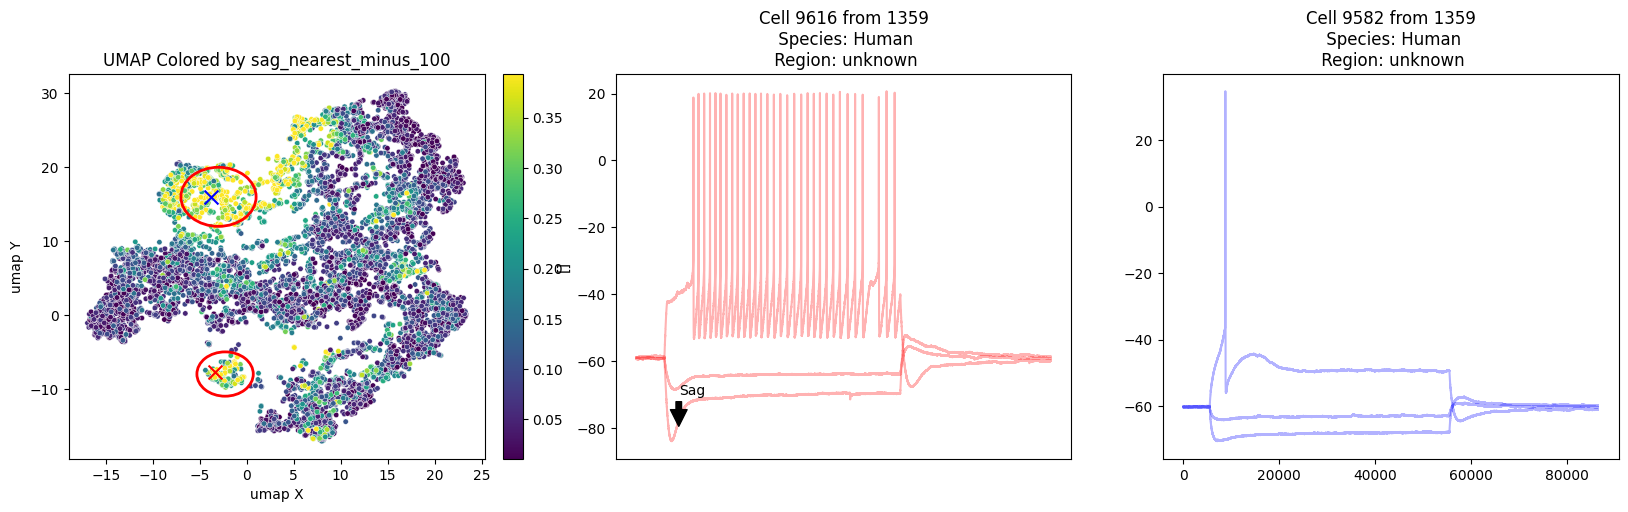

In [70]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
feature = "sag_nearest_minus_100"
clipped_feature = data[feature].clip(lower=data[feature].quantile(0.05), upper=data[feature].quantile(0.95))
sns.scatterplot(data=data, x='umap X', y='umap Y', hue=clipped_feature, palette='viridis', s=15, ax=ax[0])
ax[0].set_title(f'UMAP Colored by {feature}')
#remove the legend for clarity
ax[0].legend_.remove()
#add a colorbar
norm = plt.Normalize(vmin=clipped_feature.min(), vmax=clipped_feature.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax[0], orientation='vertical', fraction=0.046, pad=0.04)
#draw circles around the sag sections
circle1 = plt.Circle((-2.3, -8), 3, color='red', fill=False, linewidth=2)
ax[0].add_patch(circle1)
circle2 = plt.Circle((-3, 16), 4, color='red', fill=False, linewidth=2)
ax[0].add_patch(circle2)
#pick out 2 cells closest to the center of the circles
center1 = np.array([-2.3, -8])
center2 = np.array([-3, 16])
umap_coords = data[['umap X', 'umap Y']].values
#get cells within the circles, then pick the one with highest sag value
distances1 = np.linalg.norm(umap_coords - center1, axis=1)
#get indices of cells within the circle
within_circle1 = np.where(distances1 < 3)[0]
#pick the cell with the highest sag value
closest_cell1 = within_circle1[np.argmax(data.loc[within_circle1, feature].values)]
distances2 = np.linalg.norm(umap_coords - center2, axis=1)
#get indices of cells within the circle
within_circle2 = np.where(distances2 < 4)[0]
#pick the cell with the highest sag value
closest_cell2 = within_circle2[np.argmax(data.loc[within_circle2, feature].values)]

#put 'x' markers on the closest cells
ax[0].scatter(data.loc[closest_cell1, 'umap X'], data.loc[closest_cell1, 'umap Y'], color='red', s=100, marker='x')
ax[0].scatter(data.loc[closest_cell2, 'umap X'], data.loc[closest_cell2, 'umap Y'], color='blue', s=100, marker='x')
for i, cell_in in enumerate([closest_cell1, closest_cell2]):
    cell_path = data.loc[cell_in, 'specimen_id']
    cell_region = data.loc[cell_in, 'brain_region']
    cell_species = data.loc[cell_in, 'species']
    primairy_cell = plot_data(0, [os.path.join(folder, cell_path)],target_amps=[-100, 0, 10, 100] , overwrite=True, save=False, stim_override='')
    for sweep_y in primairy_cell['sweep_ys']:
        ax[i+1].plot(sweep_y, color='r' if i==0 else 'b', alpha=0.3, )
    ax[i+1].set_title(f'Cell {cell_in} from {data.loc[cell_in, "dandiset_id"]}\n Species: {cell_species}\n Region: {cell_region}')
    plt.close(primairy_cell['fig_trace']); plt.close(primairy_cell['fi_fig'])
ax[1].set_ylabel([])
ax[1].set_xticks([])
clear_output()
#label the sag on cell 1
ax[1].annotate('Sag', xy=(9.e3, -80), xytext=(9.e3,-70),
            arrowprops=dict(facecolor='black', shrink=0.05))

fig.show()
print(f"Closest cell to circle 1: {closest_cell1}, sag value: {data.loc[closest_cell1, feature]}")
print(f"Closest cell to circle 2: {closest_cell2}, sag value: {data.loc[closest_cell2, feature]}")

Interestingly, we identified two cells with different sag phenotypes, both from the human dataset. 

## The latency corner:

The feature 'latency_0_long_square' refers to the latency to the first spike. A cell with a long latency may have distinct computational properties that regulate its overall excitability. We can see that cells with a long latency cluster into the northeast corner of the UMAP space.

/tmp/ipykernel_1156517/441696098.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


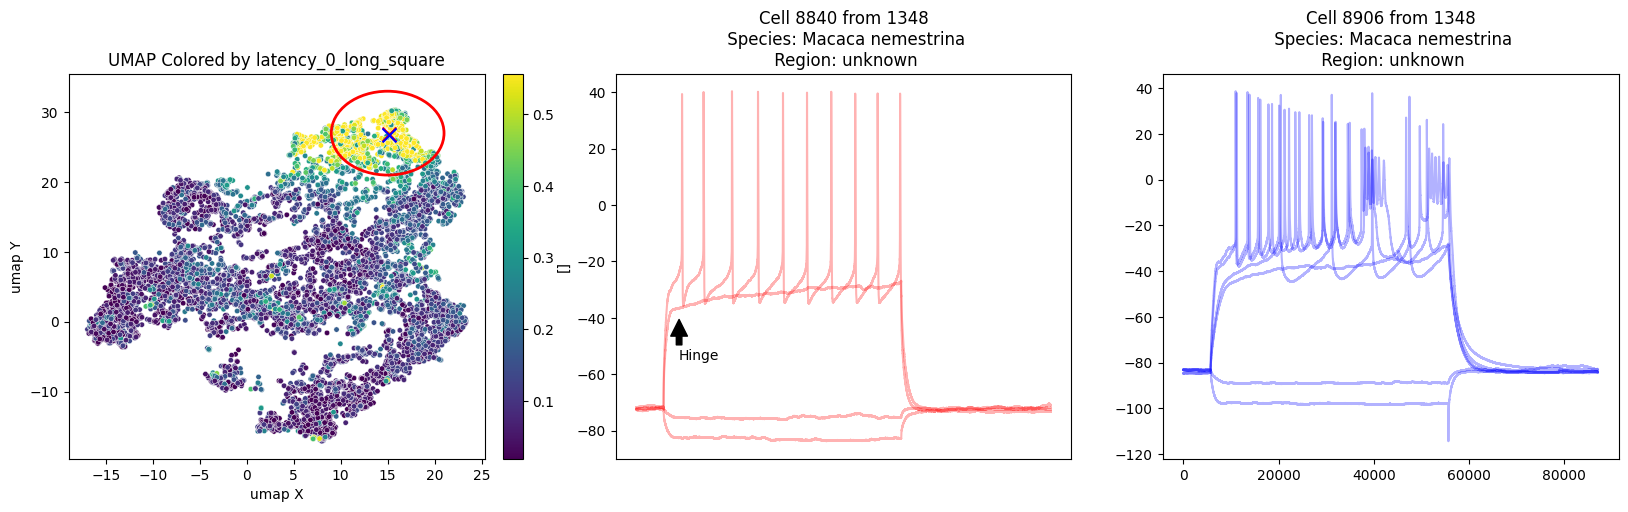

In [71]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
feature = "latency_0_long_square"
clipped_feature = data[feature].clip(lower=data[feature].quantile(0.05), upper=data[feature].quantile(0.95))
sns.scatterplot(data=data, x='umap X', y='umap Y', hue=clipped_feature, palette='viridis', s=15, ax=ax[0])
ax[0].set_title(f'UMAP Colored by {feature}')
#remove the legend for clarity
ax[0].legend_.remove()
#add a colorbar
norm = plt.Normalize(vmin=clipped_feature.min(), vmax=clipped_feature.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax[0], orientation='vertical', fraction=0.046, pad=0.04)
#draw circles around the sag sections
circle1 = plt.Circle((15, 27), 6, color='red', fill=False, linewidth=2)
ax[0].add_patch(circle1)
#pick out 2 cells closest to the center of the circles
center1 = np.array([15, 27])
umap_coords = data[['umap X', 'umap Y']].values
distances1 = np.linalg.norm(umap_coords - center1, axis=1)
closest_cell1 = np.argmin(distances1)
closest_cell2 = np.argsort(distances1)[1]
print(f"Closest cell to circle 1: {closest_cell1}, latency value: {data.loc[closest_cell1, feature]}")
print(f"Closest cell to circle 2: {closest_cell2}, latency value: {data.loc[closest_cell2, feature]}")
#put 'x' markers on the closest cells
ax[0].scatter(data.loc[closest_cell1, 'umap X'], data.loc[closest_cell1, 'umap Y'], color='red', s=100, marker='x')
ax[0].scatter(data.loc[closest_cell2, 'umap X'], data.loc[closest_cell2, 'umap Y'], color='blue', s=100, marker='x')
for i, cell_in in enumerate([closest_cell1, closest_cell2]):
    cell_path = data.loc[cell_in, 'specimen_id']
    cell_region = data.loc[cell_in, 'brain_region']
    cell_species = data.loc[cell_in, 'species']
    primairy_cell = plot_data(0, [os.path.join(folder, cell_path)], overwrite=True, save=False, stim_override='')
    for sweep_y in primairy_cell['sweep_ys']:
        ax[i+1].plot(sweep_y, color='r' if i==0 else 'b', alpha=0.3, )
    ax[i+1].set_title(f'Cell {cell_in} from {data.loc[cell_in, "dandiset_id"]}\n Species: {cell_species}\n Region: {cell_region}')
    plt.close(primairy_cell['fig_trace']); plt.close(primairy_cell['fi_fig'])
ax[1].set_ylabel([])
ax[1].set_xticks([])
#label the hinge on cell 1
ax[1].annotate('Hinge', xy=(9.e3, -40), xytext=(9.e3,-55),
            arrowprops=dict(facecolor='black', shrink=0.05))

clear_output()
fig.show()

Here are two cells with high latency values. The waveforms of the cells show a characteristic 'shoulder' or 'hinge' that is indicative of an A-type current. In my primary brain region of study (the paraventricular nucleus [PVN] of the hypothalamus), we see a lot of [A-type current](https://doi.org/10.1111/j.1469-7793.2000.t01-1-00193) in the neuroendocrine magnocellular neurons. Critically, this a-type current is an important regulator of cellular excitability, with the a-type currents being a target of [NMDA-driven modulation in magnocellular neurons](https://physoc.onlinelibrary.wiley.com/doi/full/10.1113/jphysiol.2014.270793). Its really cool to see it here too!

# The process

***NOTE**: Most of this code was generated prior to the various updates to the NWB standard and the package `ipfx`. Many of the problems discussed below are now fixed through various QoL updates.

### Part 1: Getting a consistent protocol

The first step in collating the data is finding some common features to analyze. With this in mind, I had to choose a common protocol for extracting features. In this case, I choose to extract features from the "long-pulse" current-clamp stimulation protocol. A "long-pulse" protocol is a semi-standard protocol used by patch-clampers to characterize fundamental intrinsic properties of neurons. All of the above voltage traces come from long-pulse protocols. In most cases, the protocol consists of a baseline state, and then a 'long' (typically 0.7 - 2s) epoch of current stimulation. For each sweep of stimulation, the applied current is incremented, typically ranging from -100 to 100+ pA. 


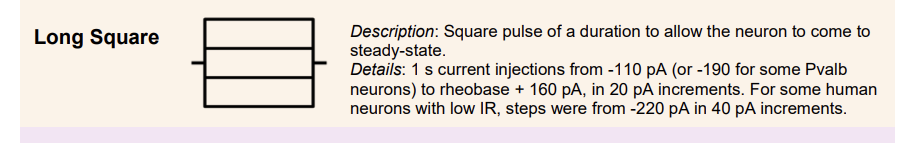  
IMAGE: An example long pulse protocol from the [allen cell types of database](https://celltypes.brain-map.org/). 

However, I ran into a problem. Many of the datasets used did not have an explicitly labelled 'long-pulse'. As such, we had to figure out which sweeps in each dataset were the 'long-pulse' ones. I tried several methods to easily detect long-pulse sweeps, including machine learn techniques. In the end, I relied on simple conditional programming to filter out the long pulse. The code looks like this:

In [72]:
def match_long_square_protocol(i, t, start_idx, end_idx):
    #here we will do some analysis to determine if the stimulus is a long square, and if so, what the parameters are
    fs = 1/(t[1]  - t[0])

    di = np.diff(i)
    di_idx = np.flatnonzero(di)   # != 0

    if len(di_idx) == 0:
        #if there are no up/down transitions, then this is not a long square, or a zero-pulse long square but we will just have to accept that for now
        return None
    if len(di_idx) == 1:
        #if there is only one up/down transition, then this is not a long square
        return None

    #check if its a long square by fitting a line to the dataset,
    #and checking if the slope is 0
    #if the slope is 0, then it is a long square
    #if the slope is not 0, then it is not a long square
    if len(di_idx) > 6:
        y_data = i[start_idx: end_idx]
        x_data = t[start_idx: end_idx]
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x_data, y_data)
        if slope < 0.1 and p_value < 0.05 and r_value > 0.6:
            return 'Long Square'
        elif slope > 0.1 and p_value > 0.05:
            return 'Long Square'
        else:
            return None
    #ensure that the stim starts at 0, and ends at 0
    if i[0] != 0:
        return None
    if i[-1] != 0:
        return None
    

    return "Long Square"

## Part 2: Getting the files through ipfx

The next step was processing all the files using a consistent method. For the electrophysiological feature extraction, I relied on Allen Institute's excellent (ifpx)[https://ipfx.readthedocs.io/en/latest/]. When I started this project, ipfx was still in its infancy. Ipfx supported NWBs but had a few clauses specific to Allen Institutes-generated NWBs that made it hard to use with third-party-generated NWBs. Regardless, we will be using ipfx's [long-square analysis](https://ipfx.readthedocs.io/en/latest/auto_examples/analysis_examples/lsq_analysis.html#sphx-glr-auto-examples-analysis-examples-lsq-analysis-py) to extract consistent features for each cell.

In the end, I had to override a few ipfx functions to get third-party NWB's to pass through. For example, the old `get_stim_characteristics` function used by ipfx to identify long pulses assumes the presence of a short test-pulse (250ms) at the start of each sweep. Unfortunately, if a dataset did not feature a test pulse, it would fail at this step. Here, we override the function to guess whether there is a test pulse:

In [73]:
#======== IPFX functions ===========
#clone the function from ipfx/stimulus_protocol_analysis.py
# here we will modify it to handle test pulses intelligently, then overwrite the function in ipfx for this session

def get_stim_characteristics(i, t, test_pulse=True, start_epoch=None, end_epoch=None, test_pulse_length=0.250):
    """
    Identify the start time, duration, amplitude, start index, and end index of a general stimulus.
    """
    fs = 1/(t[1]  - t[0])
    di = np.diff(i)
    di_idx = np.flatnonzero(di)   # != 0
    start_idx_idx = 0
    
    
    if len(di_idx[start_idx_idx:]) == 0:    # if no stimulus is found
        return None, None, 0.0, None, None

    #here we will check if the first up/down is a test pulse, and skip it if it is
    #we are assuming that the test pulse is within the first 250ms of the stimulus
    #TODO make this more robust
    if len(di_idx) > 3: # if there are more than 3 up/down transitions, there is probably a test pulse
        if (di_idx[1]) < test_pulse_length*fs: # skip the first up/down (test pulse) if present, and with in the first 250ms
            start_idx_idx = 2
        else:
            start_idx_idx = 0
    elif len(di_idx) < 3:
        start_idx_idx = 0

    start_idx = di_idx[start_idx_idx] + 1   # shift by one to compensate for diff()
    end_idx = di_idx[-1]
    if start_idx >= end_idx: # sweep has been cut off before stimulus end
        return None, None, 0.0, None, None

    start_time = float(t[start_idx])
    duration = float(t[end_idx] - t[start_idx-1])

    stim = i[start_idx:end_idx+1]

    peak_high = max(stim)
    peak_low = min(stim)

    if abs(peak_high) > abs(peak_low):
        amplitude = float(peak_high)
    else:
        amplitude = float(peak_low)

    return start_time, duration, amplitude, start_idx, end_idx
#overwrite the function in ipfx
#ipfx.stim_features.get_stim_characteristics = get_stim_characteristics

## Part 3: Finding some metadata

I wanted to pull both the species and the brain region for each recorded cell. NWB has several metadata fields; however, I found that the metadata was not consistently placed on the asset or dandiset page. To this end, I opted to try out my first LLM interface project. Here, I asked the LLM to extract the region and species. I prompted the LLM with the dandiset title, description, and asset metadata. A version of the code is below.

In [74]:
SYSTEM_PROMPT = """You are a neuroscience metadata extraction expert. Your task is to analyze scientific dataset metadata and extract key information about brain regions studied.

Based on the provided metadata (title, description, keywords, and species), identify the brain region(s) studied in the research.

Return ONLY valid JSON in this exact format:
{
  "brain_region": "region name (1-3 words)",
  "confidence": "high/medium/low",
  "reasoning": "brief explanation"
}

Guidelines:
- Use standard anatomical terminology (e.g., "motor cortex", "hippocampus", "visual cortex")
- If multiple regions, list the primary one
- If unclear or not specified, use "unknown" for brain_region with "low" confidence
- Keep brain_region concise (1-3 words maximum)
- Be specific when possible (e.g., "primary visual cortex" rather than just "cortex")
"""
class dandi_meta_parser():
    def __init__(self, dandiset_id):
        self.dandiset_id = dandiset_id
        self.client = DandiAPIClient("https://api.dandiarchive.org/api/")
        self.dandiset = self.client.get_dandiset(dandiset_id)
        self.metadata = self.dandiset.get_raw_metadata()
        self.dandiset_name = self.metadata['name']
        self.dandiset_description = self.metadata['description'] if 'description' in self.metadata else None
        self.dandiset_keywords = self.metadata['keywords'] if 'keywords' in self.metadata else None
        self.first_contributor = self.metadata['contributor'][0]['name']

        self.dandiset_species = self.metadata['assetsSummary'][
            'species'] if 'species' in self.metadata['assetsSummary'] else None
        self.dandiset_brain_region = self.determine_brain_region()
        self.asset_data = self.build_asset_data()
        print(
            f"Metadata parsed for dandiset {self.dandiset_id}, found {len(self.asset_data)} assets")
        print(f"Brain region: {self.dandiset_brain_region}")

    def build_asset_data(self):
        asset_data = []
        for asset in self.dandiset.get_assets():
            meta_asst = asset.get_metadata()
            try:
                # figure out the age
                age = pd.Timedelta(meta_asst.wasAttributedTo[0].age.value).days
                subject_id = meta_asst.wasAttributedTo[0].id if meta_asst.wasAttributedTo[
                    0].id != None else meta_asst.wasAttributedTo[0].identifier
                cell_id = meta_asst.wasGeneratedBy[0].id if meta_asst.wasGeneratedBy[
                    0].id != None else meta_asst.wasGeneratedBy[0].identifier
                species = meta_asst.wasAttributedTo[0].species.name if meta_asst.wasAttributedTo[
                    0].species != None else self.dandiset_species
                filepath = meta_asst.path

                # make the index a concat of the dandiset_id and the filepath
                idxs = self.dandiset_id + '/' + filepath
                asset_data.append({'idxs': idxs, 'dandiset_id': self.dandiset_id, 'age': age, 'subject_id': subject_id,
                                   'cell_id': cell_id, 'brain_region': self.dandiset_brain_region, 'species': species, 'filepath': filepath, 'contributor': self.first_contributor})
            except:
                asset_data.append({'idxs': self.dandiset_id + '/' + meta_asst.path, 'dandiset_id': self.dandiset_id, 'age': None, 'subject_id': None,
                                   'cell_id': None, 'brain_region': self.dandiset_brain_region, 'species': self.dandiset_species, 'filepath': meta_asst.path, 'contributor': self.first_contributor})
        return pd.DataFrame.from_dict(asset_data).set_index('idxs')

    def determine_brain_region(self):
        """Extract brain region from metadata using AI with structured JSON output."""
        # Build the query prompt
        query = f"""Now analyze this dataset:
            Title: {self.dandiset_name}
            Description: {self.dandiset_description}
            Keywords: {self.dandiset_keywords}
            Species: {self.dandiset_species}

            Response:"""
        
        # Combine system prompt, examples, and query
        full_prompt = f"{SYSTEM_PROMPT}\n\n{EXAMPLE_PROMPT}\n\n{query}"
        
        
        # Call Cohere API
        extraction = co.chat(
            message=full_prompt,
            temperature=0.3,  # Lower temperature for more consistent output
        )
        
        response_text = extraction.text.strip()
        
        # Try to parse JSON from response
        # Sometimes the model adds text before/after JSON, so find the JSON block
        json_start = response_text.find('{')
        json_end = response_text.rfind('}') + 1
        
        if json_start >= 0 and json_end > json_start:
            json_str = response_text[json_start:json_end]
            result = json.loads(json_str)
            
            brain_region = result.get('brain_region', 'unknown')
            confidence = result.get('confidence', 'unknown')
            reasoning = result.get('reasoning', '')
            
            # Log the structured result
            log_entry = {
                'prompt': query,
                'dandiset_id': self.dandiset_id,
                'title': self.dandiset_name,
                'brain_region': brain_region,
                'confidence': confidence,
                'reasoning': reasoning,
                'raw_response': response_text
            }
            
            with open('prompt.txt', 'a') as f:
                f.write(json.dumps(log_entry, indent=2) + '\n\n')
            
            return brain_region
        else:
            # Fallback: no JSON found, use raw text
            print(f"Warning: Could not parse JSON from response for {self.dandiset_id}")
            with open('prompt.txt', 'a') as f:
                f.write(f"PARSE ERROR for {self.dandiset_id}:\n{response_text}\n\n")
            return response_text.strip()
                

### One final check:

As a final sanity check, we can examine the feature distributions and perform a rough QC. Many of the features have known reasonable physiological ranges. For example, we know that v_baseline probably should be higher than -100 mV and below 0 mV (being generous). 

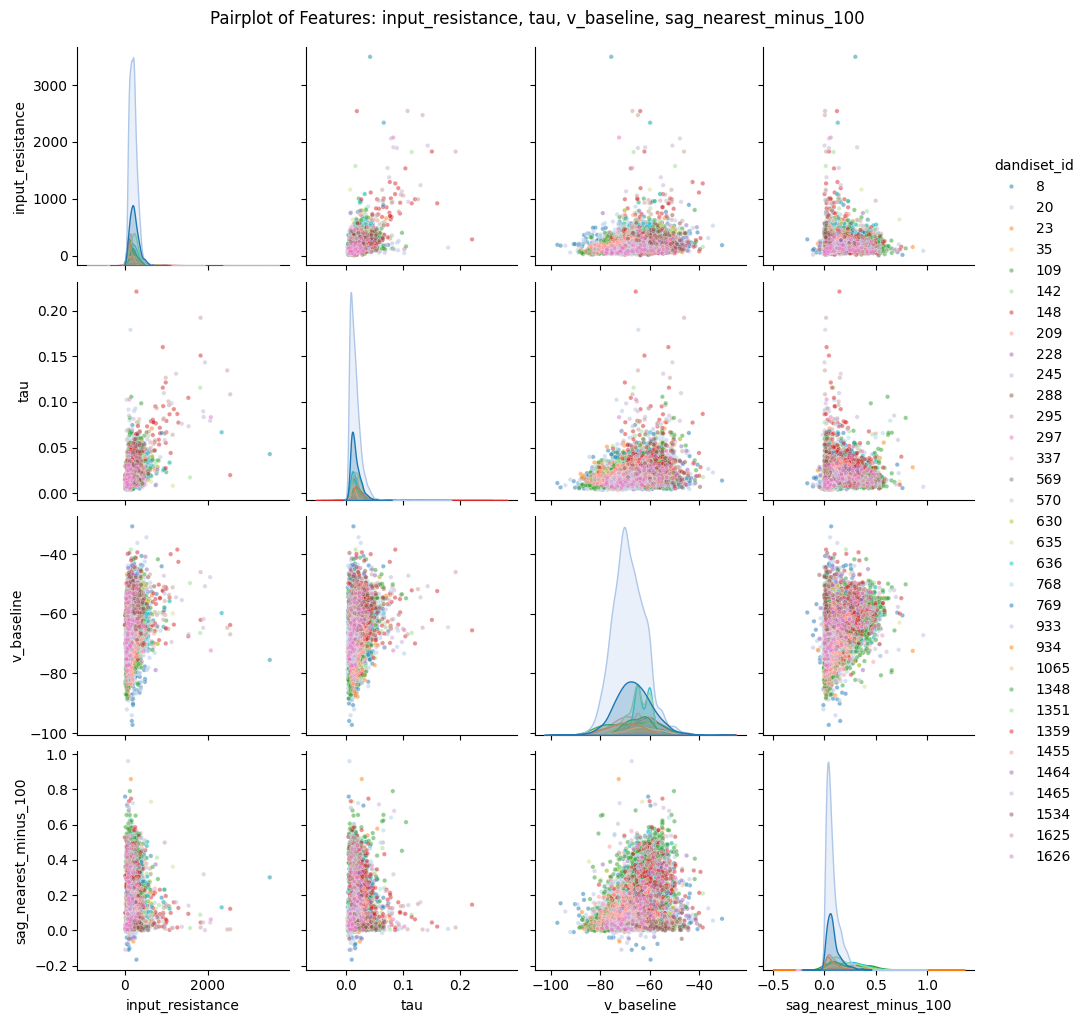

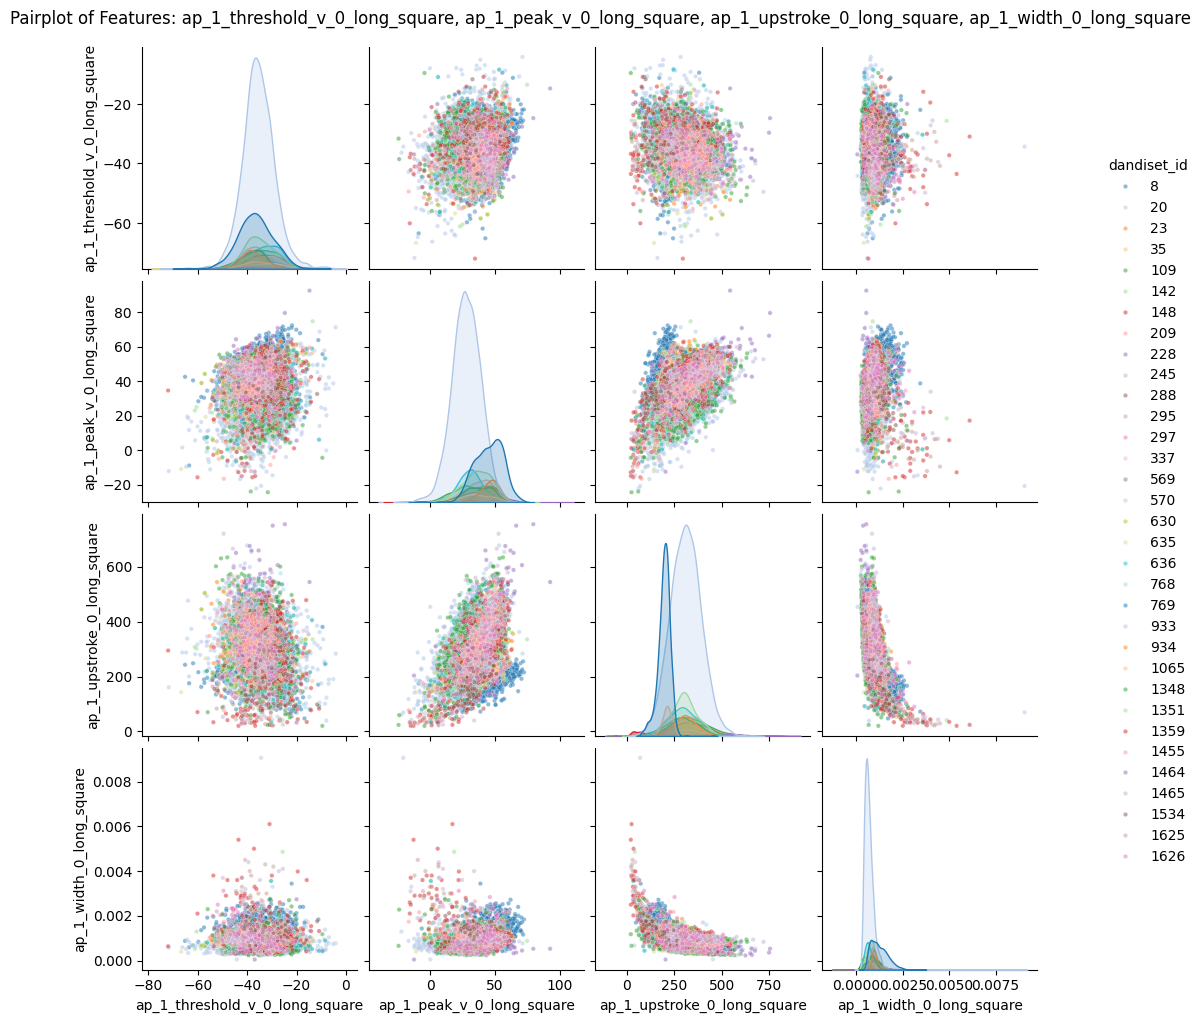

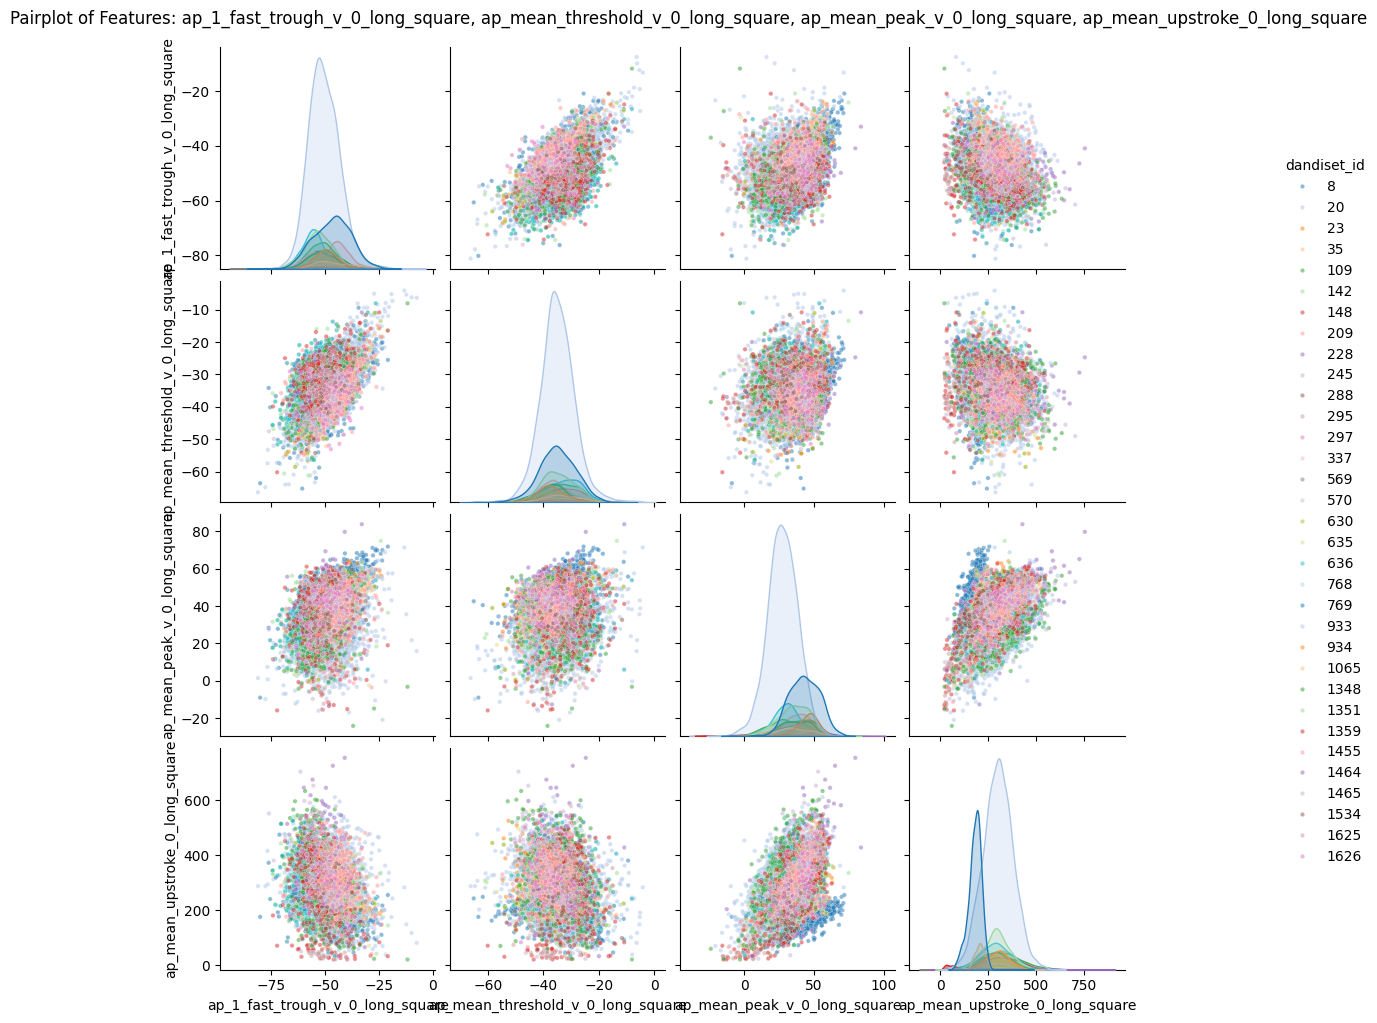

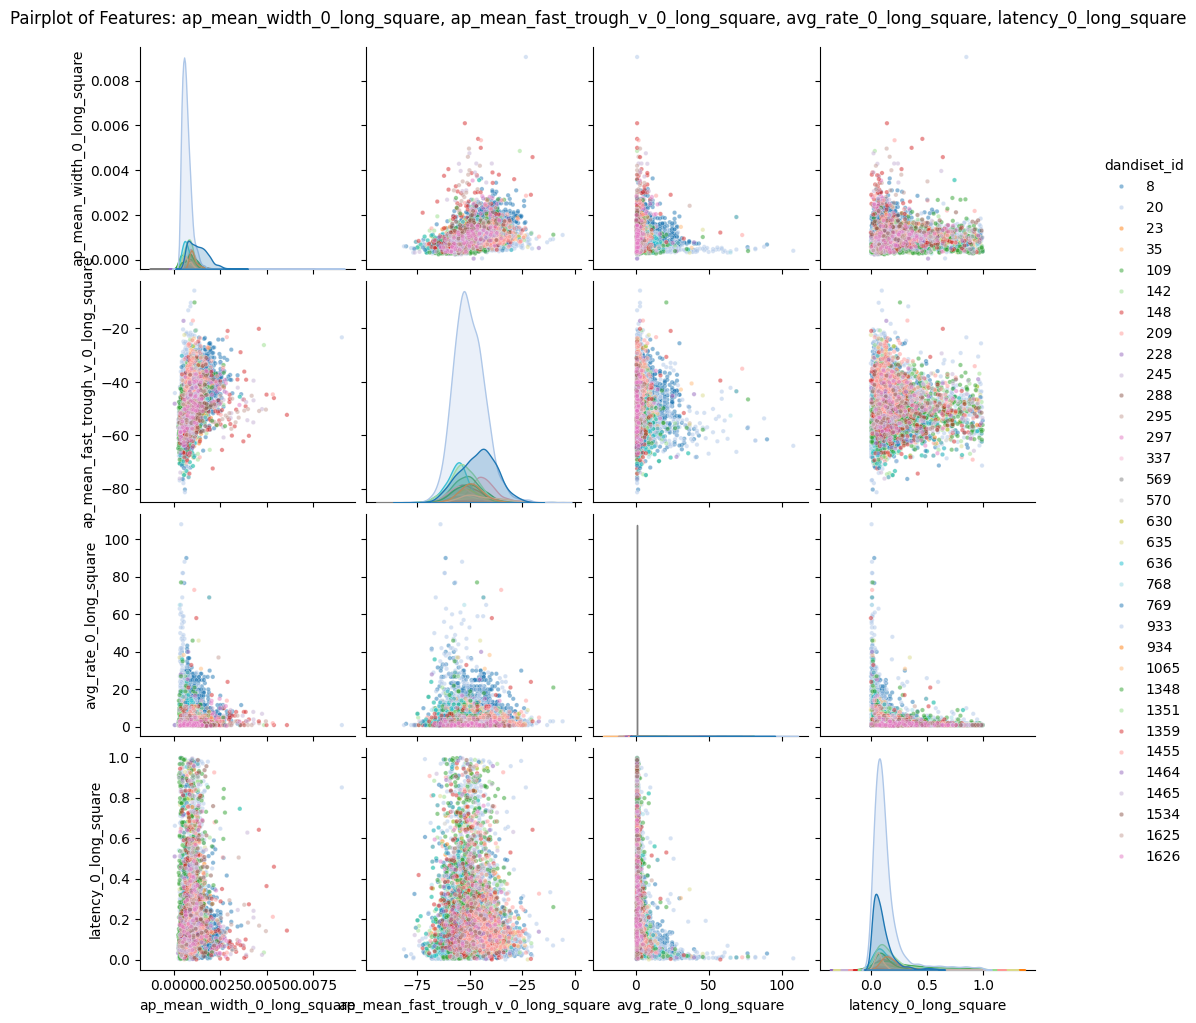

In [75]:

def quick_qc(df, qc_features={'input_resistance':[0, 1e9],'sag_nearest_minus_100':[-1, 1],
                             'ap_1_threshold_v_0_long_square':[-100, 100],
                             'tau':[(0.01/1000), (0.6)],
                             'ap_1_width_0_long_square':[(0.01/1000), (10/1000)],
                             'ap_1_fast_trough_v_0_long_square':[-100, 0],
                             'avg_rate_0_long_square':[0, 500]
                             }):
    #this is a quick qc function to check if the data is good, specifically for the output of the analyze_dandiset function
    for feature, (min_val, max_val) in qc_features.items():
        if feature in df.columns:
            #get number of failing values for logging
            _failing = df[(df[feature] < min_val) | (df[feature] > max_val)]
            num_failing = len(_failing)
            print(f"QC: {num_failing} cells failed {feature} check ({min_val} to {max_val}), examples:\n {_failing[feature].head()}")
            df = df[(df[feature] >= min_val) & (df[feature] <= max_val)]

   
    return df

#run 4 pairplots for some features
for i in range(0, len(features_used), 4):
    subset = features_used[i:i+4]
    sns.pairplot(data, vars=subset, hue='dandiset_id', palette='tab20', diag_kind='kde', plot_kws={'alpha':0.5, 's':10})
    plt.suptitle(f'Pairplot of Features: {", ".join(subset)}', y=1.02)
    plt.show()
